# Implementing Convolutional Neural Network

#### Installing essential libraries

In [49]:
!pip install tensorflow

In [50]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

#### Reading the dataset

In [51]:
df=pd.read_csv("C:/Users/riddh/OneDrive/Documents/Projects/Churn/Preprocessed_data.xls")

#### Splitting the data

In [52]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [53]:
# Convert data types to float32
X = X.astype('float32')
y = y.astype('float32')

#### Split data into training, validation, and test sets

In [54]:
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#### Check the dimension of the sets

In [55]:
print('X_train:',np.shape(X_train))
print('y_train:',np.shape(y_train))
print('X_test:',np.shape(X_test))
print('y_test:',np.shape(y_test))

X_train: (4930, 36)
y_train: (4930,)
X_test: (1057, 36)
y_test: (1057,)


#### Checking Distribution of Classes

In [56]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0.0: 3635, 1.0: 1295}


#### Reshaping of Data

In [57]:
X_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = np.array(X_val).reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

In [58]:
# Check the dimensions of the sets
print('X_train:', np.shape(X_train))
print('y_train:', np.shape(y_train))
print('X_val:', np.shape(X_val))
print('y_val:', np.shape(y_val))
print('X_test:', np.shape(X_test))
print('y_test:', np.shape(y_test))

X_train: (4930, 36, 1)
y_train: (4930,)
X_val: (1056, 36, 1)
y_val: (1056,)
X_test: (1057, 36, 1)
y_test: (1057,)


#### This code converts the X_train data by first cleaning it to replace any boolean values with integers, then converting the cleaned data into a NumPy array of type float32, and finally converting that array into a TensorFlow tensor.

In [59]:
X_train_cleaned = np.array([[int(x) if isinstance(x, bool) else x for x in row] for row in X_train])
X_train_cleaned = np.array(X_train_cleaned, dtype=np.float32)
X_train = tf.convert_to_tensor(X_train_cleaned)

In [60]:
X_val_cleaned = np.array([[int(x) if isinstance(x, bool) else x for x in row] for row in X_val])
X_val_cleaned = np.array(X_val_cleaned, dtype=np.float32)
X_val = tf.convert_to_tensor(X_val_cleaned)

In [61]:
X_test_cleaned = np.array([[int(x) if isinstance(x, bool) else x for x in row] for row in X_test])
X_test_cleaned = np.array(X_test_cleaned, dtype=np.float32)
X_test = tf.convert_to_tensor(X_test_cleaned)

#### Model Designing

In [62]:
# Build CNN model
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='sigmoid', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='sigmoid'),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(128, activation='sigmoid'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

C:\Users\riddh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Compiling the model

In [63]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
#Print a summary of the model architecture including the types of layers,
#output shapes, and the number of parameters in each layer
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 34, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 17, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 15, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,753 (323.25 KB)

 Trainable params: 82,753 (323.25 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Fit Model
epochs = 100
history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=32, 
                   callbacks=[early_stopping])

Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6887 - loss: 0.6422 - val_accuracy: 0.7556 - val_loss: 0.5620
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7273 - loss: 0.5961 - val_accuracy: 0.7556 - val_loss: 0.5632
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7269 - loss: 0.5916 - val_accuracy: 0.7556 - val_loss: 0.5646
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7295 - loss: 0.5879 - val_accuracy: 0.7556 - val_loss: 0.5556
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7236 - loss: 0.5943 - val_accuracy: 0.7556 - val_loss: 0.5502
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7468 - loss: 0.5602 - val_accuracy: 0.8012 - val_loss: 0.4883
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7553 - loss: 0.4968 - val_accuracy: 0.7961 - val_loss: 0.4374
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7913 - loss: 0.4698 - val_accu

#### Evaluate the Model

In [66]:
# Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8045 - loss: 0.4035
Test Loss: 0.4200904369354248
Test Accuracy: 0.7994323372840881


In [67]:
yhat_test_prob = model.predict(X_test)
yhat_test = (yhat_test_prob > 0.5).astype(int)

from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(y_test, yhat_test)
print('Confusion Matrix:')
print(conf_matrix)

print('Classification Report:')
print(classification_report(y_test, yhat_test))


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Confusion Matrix:
[[693  68]
 [144 152]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87       761
         1.0       0.69      0.51      0.59       296

    accuracy                           0.80      1057
   macro avg       0.76      0.71      0.73      1057
weighted avg       0.79      0.80      0.79      1057



<Axes: >

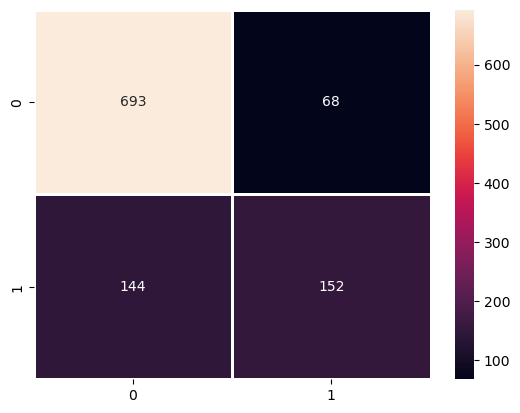

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm2=confusion_matrix(y_test, yhat_test)
sns.heatmap(cm2, linewidths=1, annot=True, fmt='g')

In [69]:
from sklearn.metrics import accuracy_score
# Printing the accuracy score
print('Accuracy:')
print(float(accuracy_score(y_test, yhat_test))*100,'%')

Accuracy:
79.94323557237465 %


In [70]:
# Printing the keys of the history object returned during model training
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


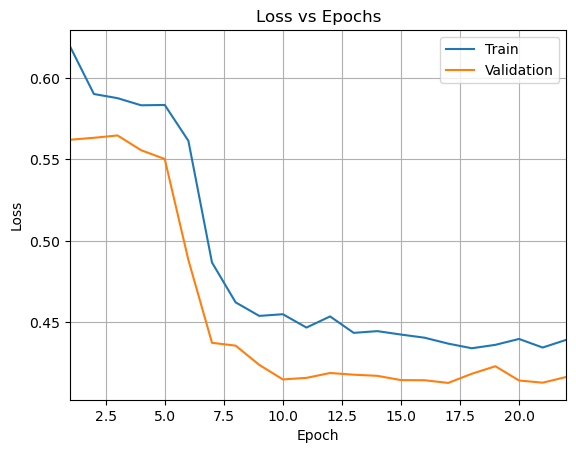

In [71]:
import matplotlib.pyplot as plt

# Define the epoch range based on the length of the loss history
epoch_range = range(1, len(history.history['loss']) + 1)

# Plot the training and validation loss over epochs
plt.plot(epoch_range, history.history['loss'], label='Train')   # Training loss
plt.plot(epoch_range, history.history['val_loss'], label='Validation')  # Validation loss

# Adding labels and title to the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.xlim((1, len(history.history['loss'])))  # Ensure x-axis limit matches the number of epochs
plt.legend()
plt.title('Loss vs Epochs')

# Displaying the plot
plt.show()


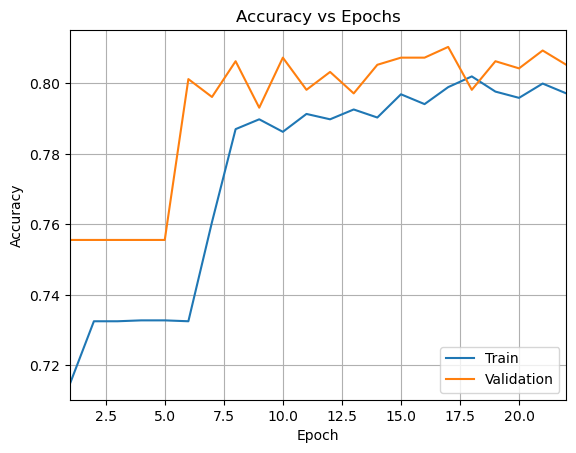

In [72]:
import matplotlib.pyplot as plt

# Define the epoch range based on the length of the accuracy history
epoch_range = range(1, len(history.history['accuracy']) + 1)

# Plot the training and validation accuracy over epochs
plt.plot(epoch_range, history.history['accuracy'], label='Train')   # Training accuracy
plt.plot(epoch_range, history.history['val_accuracy'], label='Validation')  # Validation accuracy

# Adding labels and title to the plot
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.xlim((1, len(history.history['accuracy'])))  # Ensure x-axis limit matches the number of epochs
plt.legend()
plt.title('Accuracy vs Epochs')

# Displaying the plot
plt.show()